# LSTM/SelfAttention
* Weekly data, normalized and not

# Imports

In [3]:
import os
import random
import calendar
import datetime
import warnings
import logging
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery
from dotenv import load_dotenv
from pathlib import Path

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

warnings.filterwarnings("ignore")
tqdm.pandas()

In [4]:
import comet_ml
from comet_ml import Experiment, Optimizer
logging.getLogger("comet_ml").setLevel("ERROR")

import scipy.stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Config

In [5]:
# Config
PROJECT_ID = "arpae-prod-ml"

# BigQuery
JOINED_BQ_DATASET = "JOINED_DATA"
JOINED_DATA_TABLE = "SLIDING_WINDOWS_DATASET"

# Dataset path
dataset_path = "data/"

# Ouput
model_output = "models"

In [6]:
# Load Comet API Key from env
dotenv_path = Path('data/env_vars.sh')
load_dotenv(dotenv_path=dotenv_path)

COMET_API_KEY = os.getenv('COMET_API_KEY')
project_name = "arpae-ml-pollen-prediction-ht"
comet_ml_workspace = "pveronesi"

## Methods

In [7]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = list(df.cluster.sort_values().unique())
    cluster_ids.append("all")
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Load Dataset

### Load clustering results

(363, 3)


,station_id,pol_var_id,cluster
276,10,B48017,4
154,6,B48031,9
92,4,B48036,9


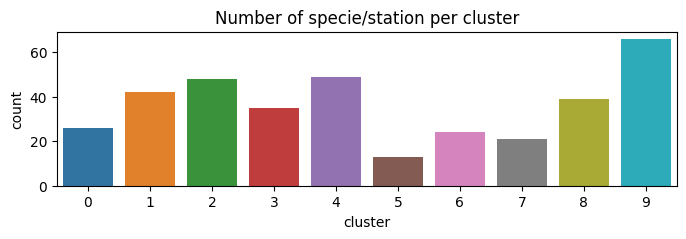

In [8]:
### Load clustering data
clusters = pd.read_csv("data/clusters/clustering_intervals.csv")

print(clusters.shape)
display(clusters.sample(3))

plt.figure(figsize=(8,2))
plt.title("Number of specie/station per cluster")
sns.countplot(x=clusters["cluster"]);

### Load dataset

In [9]:
### From BigQuery
# bq_client = bigquery.Client.from_service_account_json("data/arpae-prod-ml-f7820c528250.json")
# sql = f"SELECT * FROM `{PROJECT_ID}.{JOINED_BQ_DATASET}.{JOINED_DATA_TABLE}`"
# df_dataset = _run_query(bq_client, sql)

### From local file
df_dataset = pd.read_feather("data/dataset_7D_normalized_2023.feather")
df_dataset.drop_duplicates(inplace=True)

# Convert dates, sort and set index
df_dataset.date = pd.to_datetime(df_dataset.date)
df_dataset.sort_values(["station_id", "pol_var_id", "date"], inplace=True)
df_dataset.set_index("date", inplace=True)

In [11]:
### Dataset preview
print(df_dataset.shape)
df_dataset.head(5)

(1178889, 99)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,pol_var_id_B48034,pol_var_id_B48036,pol_var_id_B48037,pol_var_id_B48038,pol_var_id_B48039,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH,cluster
date,,,,,,,,,,,,,,,,,,,,,
2006-09-05 00:00:00+00:00,1,B48001,0.0,0.010309,0.007163,0.010346,5.140287e-03,0.555556,0.707631,0.648377,...,0,0,0,0,0,0,0,0,training,3
2006-09-06 00:00:00+00:00,1,B48001,0.0,0.010309,0.001791,0.004397,1.285072e-03,0.555556,0.707631,0.644707,...,0,0,0,0,0,0,0,0,training,3
2006-09-07 00:00:00+00:00,1,B48001,0.0,0.000000,0.000000,0.000000,6.087323e-17,0.555556,0.684836,0.625042,...,0,0,0,0,0,0,0,0,training,3
2006-09-08 00:00:00+00:00,1,B48001,0.0,0.017182,0.015519,0.011157,1.113729e-02,0.555556,0.677899,0.585648,...,0,0,0,0,0,0,0,0,training,3
2006-09-09 00:00:00+00:00,1,B48001,0.0,0.044674,0.031038,0.037994,2.227458e-02,0.555556,0.679881,0.582157,...,0,0,0,0,0,0,0,0,training,3


___

# 2. Define training parameters

In [12]:
all_features = [
    # 'station_id', 'pol_var_id', 'pol_value_label',
    # 'season_label', 'seasonal_mean', 'seasonal_prev_1',
    # 'trend_label', 'trend_mean', 'trend_prev_1',
    # 'residual_label', 'residual_mean', 'residual_prev_1',
    'week_amax',
    'B13011_min_amin', 'B13011_max_amax', 'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum',
    'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean', 'B14198_std_mean', 'B14198_sum_sum',
    #'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum',
    'station_lat_amax', 'station_lon_amax', 'station_H_piano_strada_amax', 'station_H_mslm_amax',
    #'PREC_amin', 'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew', 'PREC_kurtosis',
    'pol_value_amin', 'pol_value_mean', 'pol_value_std', 'pol_value_median', 'pol_value_amax', 'pol_value_skew', 'pol_value_kurtosis',
    'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3', 'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6', 'pol_value_prev_7',
    'station_id_1', 'station_id_2', 'station_id_4', 'station_id_5', 'station_id_6', 'station_id_7', 'station_id_8', 'station_id_9', 'station_id_10', 'station_id_11', 'station_id_13',
    'pol_var_id_B48001', 'pol_var_id_B48002', 'pol_var_id_B48003', 'pol_var_id_B48005', 'pol_var_id_B48006', 'pol_var_id_B48007', 'pol_var_id_B48008', 'pol_var_id_B48011', 'pol_var_id_B48012', 'pol_var_id_B48013', 'pol_var_id_B48015', 'pol_var_id_B48016', 'pol_var_id_B48017', 'pol_var_id_B48018', 'pol_var_id_B48019', 'pol_var_id_B48021', 'pol_var_id_B48023', 'pol_var_id_B48024', 'pol_var_id_B48025', 'pol_var_id_B48026', 'pol_var_id_B48029', 'pol_var_id_B48030', 'pol_var_id_B48031', 'pol_var_id_B48032', 'pol_var_id_B48033', 'pol_var_id_B48034', 'pol_var_id_B48036', 'pol_var_id_B48037', 'pol_var_id_B48038', 'pol_var_id_B48039', 'pol_var_id_B48041', 'pol_var_id_B48044', 'pol_var_id_B48045'
]

y_label = "pol_value_label"

print(f"Len features: {len(all_features)}")
print(f"y_label: {y_label}")

Len features: 73
y_label: pol_value_label


In [13]:
def get_dataset(cluster_n, params):
    # Create an object to store dataset and results
    class dataset: pass
    dataset.cluster_n = cluster_n

    # Create cluster training/test/validation split
    df_feature = df_dataset[df_dataset.cluster == cluster_n].copy()
    dataset.x_train = df_feature[df_feature.WHICH == "training"]
    dataset.y_train = df_feature[df_feature.WHICH == "training"][[y_label]]
    dataset.x_valid = df_feature[df_feature.WHICH == "validation"]
    dataset.y_valid = df_feature[df_feature.WHICH == "validation"][[y_label]]
    dataset.x_test = df_feature[df_feature.WHICH == "test"]
    dataset.y_test = df_feature[df_feature.WHICH == "test"][[y_label]]
    
    # Drop all-0 columns (one hot encodings)
    to_keep = [c for c in dataset.x_train.columns if dataset.x_train[c].any()]
    dataset.features = [feature for feature in all_features if feature in to_keep]

    dataset.train_dataset = timeseries_dataset_from_array(dataset.x_train[dataset.features], dataset.y_train, sequence_length=params.sequence_length, batch_size=params.batch_size)
    dataset.valid_dataset = timeseries_dataset_from_array(dataset.x_valid[dataset.features], dataset.y_valid, sequence_length=params.sequence_length, batch_size=params.batch_size)
    dataset.test_dataset = timeseries_dataset_from_array(dataset.x_test[dataset.features], dataset.y_test, sequence_length=params.sequence_length, batch_size=params.batch_size)

    return dataset

___

# 3. Model structure definition
* LSTM + MultiHeadAttention

In [14]:
model_arch_name = "LSTM+MultiHeadAttention+AdamW"

def get_model(params, feature_len):
    # Define model inputs
    input_layer = tf.keras.layers.Input(shape=(params.sequence_length, feature_len))

    # LSTM Layer
    lstm_1 = tf.keras.layers.LSTM(units=params.lstm_1_units, dropout=params.dropout, return_sequences=True)(input_layer)
    lstm_2 = tf.keras.layers.LSTM(units=params.lstm_2_units, dropout=params.dropout, return_sequences=True)(lstm_1)

    ### Multi head attention
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=lstm_2, value=lstm_2, key=lstm_2)
    attn_output = tf.keras.layers.Dense(units=params.dense_1_units)(attn_layer)

    # Reshape attention layer
    att_reshape = tf.keras.layers.Flatten()(attn_output)

    # Dense layer
    dense_lst_1 = tf.keras.layers.Dense(units=params.dense_1_units)(att_reshape)
    dropout_1 = tf.keras.layers.Dropout(params.dropout)(dense_lst_1)
    dense_lst_2 = tf.keras.layers.Dense(units=params.dense_2_units)(dropout_1)

    # Output layer
    output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

    # Define model architecture
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Optimizer
    optimizer = AdamW(learning_rate=params.learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [12]:
def train_model(dataset, params):
    model_name = f"{model_arch_name}_Cluster-{dataset.cluster_n}"
    print(f"Training model {model_name}")

    # Load model and fit dataset
    model = get_model(params=params, feature_len=len(dataset.features))

    history = model.fit(
        dataset.train_dataset,
        validation_data=dataset.valid_dataset,
        epochs=params.n_epochs,
        shuffle=params.shuffle,
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=params.patience, verbose=1, mode="min", restore_best_weights=True),
            ModelCheckpoint(f"{model_output}/{model_name}.h5", monitor="val_loss", mode="min", save_best_only=True),
            TqdmCallback(verbose=1),
        ],
    )

    return history, model

___

# 4. Training

In [13]:
# ### Choose clusters for training and test
# all_clusters = sorted(clusters.cluster.unique())

# # for debugging purpose
# all_clusters = random.sample(all_clusters, 1)
# print(f"Training on clusters: {all_clusters}")

In [14]:
# # Model parameters
# class model_params:
#     lstm_1_units = 256
#     lstm_2_units = 128
#     dense_1_units = 128
#     dense_2_units = 64
#     dropout = .2
#     learning_rate = 0.0001
#     batch_size = 1024
#     sequence_length = 7
#     n_epochs = 100
#     patience = 10
#     shuffle = True

In [15]:
# trainings = []
# for cluster_n in tqdm(all_clusters):
#     # Load model
#     model_name, model = get_model(model_params)
#     # Load dataset
#     dataset = get_dataset(cluster_n=cluster_n, params=model_params)
#     # Fit model on dataset, store results
#     dataset.model_name, dataset.history, dataset.model = train_model(dataset, model_params)
#     trainings.append(dataset)

___

# 5. Hyperparameter tuning

In [16]:
### Choose clusters for training and test
all_clusters = sorted(clusters.cluster.unique())

# for debugging purpose
# all_clusters = random.sample(all_clusters, 1)
# all_clusters = [9]

print(f"Training on clusters: {all_clusters}")

Training on clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [17]:
### Define Hyperparameters
max_combo = 15
hyperparams = {
    "algorithm": "bayes",
    "parameters": {
        "lstm_1_units": {"type": "discrete", "values": [64, 128, 256, 512]},
        "lstm_2_units": {"type": "discrete", "values": [64, 128, 256]},
        "dense_1_units": {"type": "discrete", "values": [64, 128, 256, 512]},
        "dense_2_units": {"type": "discrete", "values": [64, 128, 256]},
        "dropout": {"type": "float", "min": 0.0, "max": 0.4},
        "learning_rate": {"type": "float", "min": 0.00001, "max": 0.1},
        "batch_size": {"type": "discrete", "values": [256, 512, 1024, 2048, 4096]},
        "sequence_length": {"type": "discrete", "values": [7, 14, 21]},
        
    },
    "spec": {"maxCombo": max_combo, "objective": "minimize", "metric": "val_loss"},
    "trials": 1,
}

In [31]:
for cluster_n in tqdm(all_clusters[1:], desc=f"Hyperparameter Tuning on Cluster:"):

    # Setup CometML Optimizer and default model params
    optimizer = Optimizer(
        hyperparams,
        api_key=COMET_API_KEY, 
        project_name=project_name,
        workspace=comet_ml_workspace,
        log_env_details=False,
        display_summary_level=0,
        verbose=0
    )

    # Loop experiments
    for ith, experiment in tqdm(enumerate(optimizer.get_experiments(), start=1), total=max_combo, desc="Doing dxperiments..."):

        # Model parameters
        class HT_params:
            lstm_1_units = experiment.get_parameter("lstm_1_units")
            lstm_2_units = experiment.get_parameter("lstm_2_units")
            dense_1_units = experiment.get_parameter("dense_1_units")
            dense_2_units = experiment.get_parameter("dense_2_units")
            dropout = experiment.get_parameter("dropout")
            learning_rate = experiment.get_parameter("learning_rate")
            batch_size = experiment.get_parameter("batch_size")
            sequence_length = experiment.get_parameter("sequence_length")
            n_epochs = 100 # constant
            patience = 10 # constant
            shuffle = True # constant

        # Load dataset
        dataset = get_dataset(cluster_n=cluster_n, params=HT_params)
        
        # Load model
        model = get_model(params=HT_params, feature_len=len(dataset.features))
        experiment.set_name(f"{model_arch_name}_Cluster-{cluster_n}_hyperopt-{ith}")
        experiment.add_tag(f"{model_arch_name}_Cluster-{cluster_n}_hyperopt-{ith}")

        # Fit model on dataset
        dataset.history, dataset.model = train_model(dataset, HT_params)

        # Log test_mse
        test_mse = model.evaluate(dataset.test_dataset, verbose=False)
        experiment.log_metric("test_mse", test_mse)

        # Log test_pred_error
        test_truth = dataset.y_test.values.flatten()[:-HT_params.sequence_length+1]
        test_pred = model.predict(dataset.test_dataset, verbose=False).squeeze()
        test_pred_error = np.mean(np.abs(test_pred - test_truth))
        experiment.log_metric("test_pred_error", test_pred_error)

        # End experiment and clear tf session
        experiment.end()
        tf.keras.backend.clear_session()

Hyperparameter Tuning on Cluster::   0%|          | 0/9 [00:00<?, ?it/s]

Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 10.
Epoch 20: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 86.
Epoch 96: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 51.
Epoch 61: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping


COMET ERROR: Failed to report experiment status (experiment ended)
COMET ERROR: Heartbeat processing error


Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

COMET ERROR: Heartbeat processing error


Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping


COMET ERROR: Optimizer couldn't end


Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 81.
Epoch 91: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 55.
Epoch 65: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 26.
Epoch 36: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 74.
Epoch 84: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

COMET ERROR: Optimizer couldn't end
COMET ERROR: Error sending a notification, make sure you have opted-in for notifications


Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 32.
Epoch 42: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 23.
Epoch 33: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 10.
Epoch 20: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 70.
Epoch 80: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 42.
Epoch 52: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping


Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 77.
Epoch 87: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 13.
Epoch 23: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

COMET ERROR: Heartbeat processing error
COMET ERROR: Optimizer couldn't end


Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

COMET ERROR: Heartbeat processing error


Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 67.
Epoch 77: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 29.
Epoch 39: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping


Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 61.
Epoch 71: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 87.
Epoch 97: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 43.
Epoch 53: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping


Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 75.
Epoch 85: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 70.
Epoch 80: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 70.
Epoch 80: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 32.
Epoch 42: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 40.
Epoch 50: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 90.
Epoch 100: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 49.
Epoch 59: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 10.
Epoch 20: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 89.
Epoch 99: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 52.
Epoch 62: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping


Doing dxperiments...:   0%|          | 0/15 [00:00<?, ?it/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 46.
Epoch 56: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 39.
Epoch 49: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 80.
Epoch 90: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 38.
Epoch 48: early stopping
Training model LSTM+MultiHeadAttention+AdamW_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 65.
Epoch 75: early stopping


___

# 6. Hyperparameter selection

In [15]:
comet_ml_api = comet_ml.api.API(api_key=COMET_API_KEY)
experiments = comet_ml_api.get_experiments(project_name=project_name, workspace=comet_ml_workspace)

In [29]:
df_ht = []
to_drop = ["f", "AdamW_weight_decay", "validate_curr_step", "AdamW_name", "curr_step", "AdamW_beta_1", "AdamW_beta_2", "AdamW_ema_momentum", "AdamW_epsilon", "AdamW_amsgrad", "AdamW_ema_overwrite_frequency", "AdamW_use_ema", "AdamW_clipnorm", "AdamW_jit_compile", "AdamW_clipvalue", "AdamW_global_clipnorm", "AdamW_is_legacy_optimizer"]

for experiment in tqdm(experiments):
    # Get experiment details
    model_name, cluster_n, ht_idx = experiment.name.split("_")
    res = {
        "model_name": model_name,
        "cluster_n": cluster_n,
        "hyperopt_idx": int(ht_idx.split("-")[-1]),
    }
    
    # Get mse on test set
    test_pred_error = {"metricValue":0}
    try:
        test_pred_error = list(filter(lambda r: r["metricName"] == "test_pred_error", experiment.get_metrics()))[0]
    except:
        test_pred_error = {"metricValue":0}
    res["test_pred_error"] = float(test_pred_error["metricValue"])

    # Get hyperparameters
    for param in experiment.get_parameters_summary():
        if param["name"] not in to_drop:
            res[param["name"]] = float(param["valueMax"])
    
    # Append experiment result
    res["optimization_id"] = experiments[0].optimization_id
    df_ht.append(res)

df_ht = pd.DataFrame(df_ht)
df_ht = df_ht.iloc[-150:]
df_ht

  0%|          | 0/159 [00:00<?, ?it/s]

___

## 6.1 Get best hyperparameters for cluster

In [37]:
best_ht = df_ht.sort_values("test_pred_error").groupby("cluster_n", as_index=False).first()
best_ht.AdamW_learning_rate = best_ht.AdamW_learning_rate.round(2)
best_ht

,cluster_n,model_name,hyperopt_idx,test_pred_error,batch_size,dense_1_units,dense_2_units,dropout,learning_rate,lstm_1_units,lstm_2_units,sequence_length,optimization_id,AdamW_learning_rate,curr_epoch,epochs,steps
0,Cluster-0,LSTM+MultiHeadAttention+AdamW,14,0.000000,1024.0,256.0,128.0,0.065702,0.083539,128.0,256.0,14.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.08,56.0,100.0,64.0
1,Cluster-1,LSTM+MultiHeadAttention+AdamW,1,0.000000,4096.0,128.0,256.0,0.044907,0.026653,512.0,256.0,21.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.03,0.0,100.0,25.0
2,Cluster-2,LSTM+MultiHeadAttention+AdamW,2,0.000000,1024.0,128.0,64.0,0.031063,0.021581,64.0,64.0,14.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.02,13.0,100.0,116.0
3,Cluster-3,LSTM+MultiHeadAttention+AdamW,13,0.000000,1024.0,128.0,64.0,0.248787,0.095604,512.0,128.0,21.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.10,79.0,100.0,88.0
4,Cluster-4,LSTM+MultiHeadAttention+AdamW,3,0.000000,2048.0,64.0,64.0,0.276768,0.021266,128.0,128.0,14.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.02,86.0,100.0,45.0
5,Cluster-5,LSTM+MultiHeadAttention+AdamW,15,0.015148,2048.0,64.0,256.0,0.116679,0.098421,512.0,256.0,7.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.10,46.0,100.0,16.0
6,Cluster-6,LSTM+MultiHeadAttention+AdamW,11,0.034630,4096.0,512.0,128.0,0.160732,0.021532,512.0,128.0,7.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.02,16.0,100.0,15.0
7,Cluster-7,LSTM+MultiHeadAttention+AdamW,8,0.022092,4096.0,512.0,64.0,0.029836,0.052305,512.0,128.0,14.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.05,41.0,100.0,14.0
8,Cluster-8,LSTM+MultiHeadAttention+AdamW,7,0.016125,4096.0,64.0,256.0,0.270576,0.007139,256.0,128.0,7.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.01,99.0,100.0,24.0
9,Cluster-9,LSTM+MultiHeadAttention+AdamW,14,0.015461,256.0,64.0,256.0,0.341563,0.012901,128.0,256.0,7.0,a76abaf3f3094b12920ec2e55dd6f3b7,0.01,47.0,100.0,568.0


In [ ]:
# df_ht[df_ht.curr_epoch<99].sort_values("test_pred_error").groupby("cluster_n", as_index=False).first()

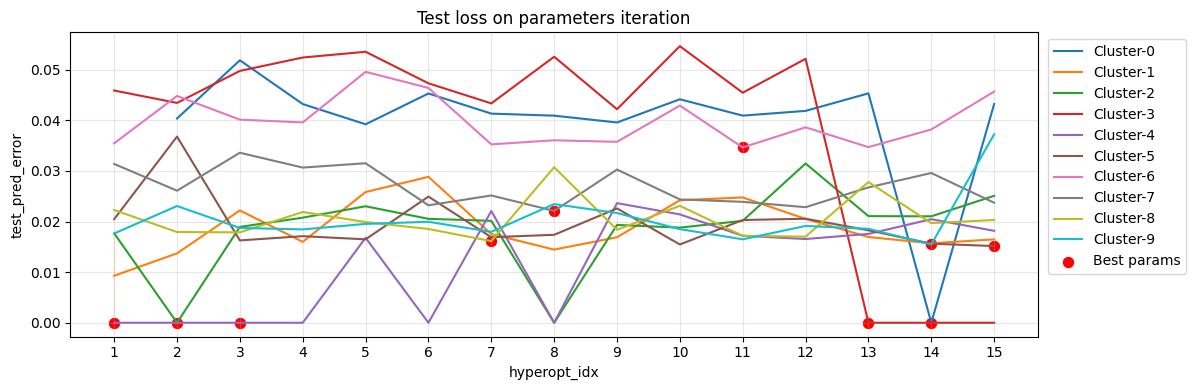

In [38]:
plt.figure(figsize=(12, 4))
plt.title("Test loss on parameters iteration")
sns.lineplot(data=df_ht, x="hyperopt_idx", y="test_pred_error", hue="cluster_n")
sns.scatterplot(data=best_ht, x="hyperopt_idx", y="test_pred_error", s=80, c="red", label="Best params")
plt.xticks(np.arange(1, df_ht.hyperopt_idx.max()+1))
plt.grid(alpha=.3)
plt.legend(loc="upper right", bbox_to_anchor=(1.16, 1))
plt.tight_layout()
plt.show()

___

## 6.2 Get global best hyperparameter
* Parameters used to train the same model for all clusters

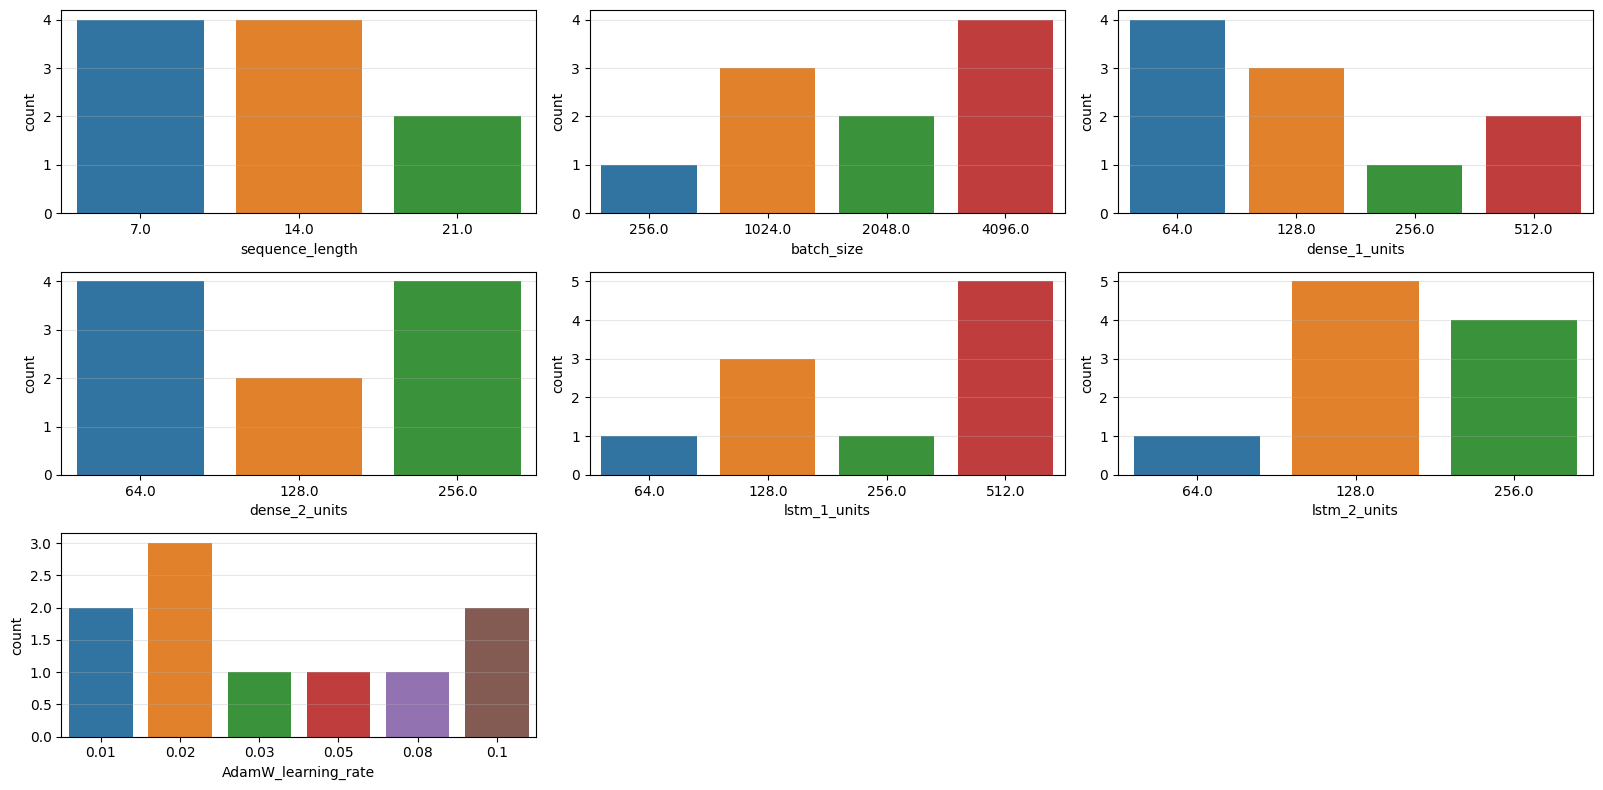

In [39]:
params = ["sequence_length", "batch_size", "dense_1_units", "dense_2_units", "lstm_1_units", "lstm_2_units", "AdamW_learning_rate"]

rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(16,8), squeeze=False)
for subpltn, param in enumerate(params):
    ax = axs[divmod(subpltn, cols)]
    ax.grid(alpha=.3)
    sns.countplot(data=best_ht, x=param, ax=ax)

for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

### Global hyperparameters

In [40]:
best_global_hp = best_ht[params].apply(pd.value_counts).idxmax()
best_global_hp

sequence_length           7.00
batch_size             4096.00
dense_1_units            64.00
dense_2_units            64.00
lstm_1_units            512.00
lstm_2_units            128.00
AdamW_learning_rate       0.02
dtype: float64

In [41]:
### If two parameters have the same max count, keep the highest value
best_global_hp = {}
for param in params:
    max_count = best_ht[param].value_counts().max()
    max_count_idx = best_ht[param].value_counts() == max_count
    best_global_hp[param] = best_ht[param].value_counts()[max_count_idx].index.max()
best_global_hp

{'sequence_length': 14.0,
 'batch_size': 4096.0,
 'dense_1_units': 64.0,
 'dense_2_units': 256.0,
 'lstm_1_units': 512.0,
 'lstm_2_units': 128.0,
 'AdamW_learning_rate': 0.02}